# Création d'un dataset d'ordre de lecture sur PubLayNet

In [ ]:
!pip install Unidecode
!pip install fuzzysearch

!pip install elementpath
!pip install lxml 
!pip install graphviz
!pip install pydotplus

In [1]:
!ls ../../edspdf-train/data/publaynet/

dev.json xmls


# Sorting lines based on the xml files

In [1]:
from sort_xml import *
base_dir = '../../edspdf-train/data/publaynet/'

%load_ext autoreload
%autoreload 2

import sys
sys.executable

'/Users/souleymbaye/opt/anaconda3/envs/eds_env/bin/python'

In [2]:
import os

from pathlib import Path
import json

### Load pdf and xml example 

In [3]:
xmls_dir = base_dir + 'xmls/'
dev_path = base_dir + 'dev.json'

with open(Path(dev_path)) as f:
    samples = json.load(f)

# load xml files
xmls_names = {} # {pmc = {xml_fname, pdf_fname}}
for root, directories, files in os.walk(xmls_dir):
    for pmc in directories:
        fdir = xmls_dir + pmc
        for root2, directories2, files2 in os.walk(fdir):
            xml_fname = None
            pdfs_fnames = []
            for file in files2:
                if file.split('.')[-1] == 'nxml':
                    xml_fname = file
                if file.split('.')[-1] == 'pdf':
                    pdfs_fnames.append(file)

            lenghts = [len(pf) for pf in pdfs_fnames]
            # if len(lenghts) == 0:
            #   print(f'fdir ==> {fdir}')

            i_min = np.argmin(lenghts)
            xmls_names[pmc] = {'xml' :xml_fname, 'pdf': pdfs_fnames[i_min], 'page_num': None}
    break
# end load xml files
    
    
for image in samples['images']:
    pmc = image['file_name'].split('_')[0]
    if pmc in xmls_names:
        page_num = int(image['file_name'].split('_')[1].split('.')[0])
        xmls_names[pmc]['page_num'] = page_num


In [4]:
for k,v in xmls_names.items():
    print(f'k: {k} -> v: {v}')
    break

k: PMC1253713 -> v: {'xml': 'ehp0113-000073.nxml', 'pdf': 'ehp0113-000073.pdf', 'page_num': 3}


## Model extractor

In [5]:
from edspdf import Pipeline
from edspdf.structures import Box, PDFDoc
from edspdf.visualization.annotations import show_annotations

# model
model = Pipeline()
model.add_pipe("pdfminer-extractor", config=dict(extract_style="true"), name="extractor")

In [6]:
# SUITE TO DO
file_dir = base_dir + 'xmls/PMC1247606'
pdf_path, xml_path = get_paths(file_dir = file_dir)
print(f'xml path: {xml_path}\npdf path: {pdf_path}')


xml path: ../../edspdf-train/data/publaynet/xmls/PMC1247606/ehp0112-001447.nxml
pdf path: ../../edspdf-train/data/publaynet/xmls/PMC1247606/ehp0112-001447.pdf


#### Display XML

Page num 2
front nodes ok
body nodes ok
table 1 / 6 ok
table 2 / 6 ok
table 3 / 6 ok
table 4 / 6 ok
table 5 / 6 ok
table 6 / 6 ok
Nb pages 6


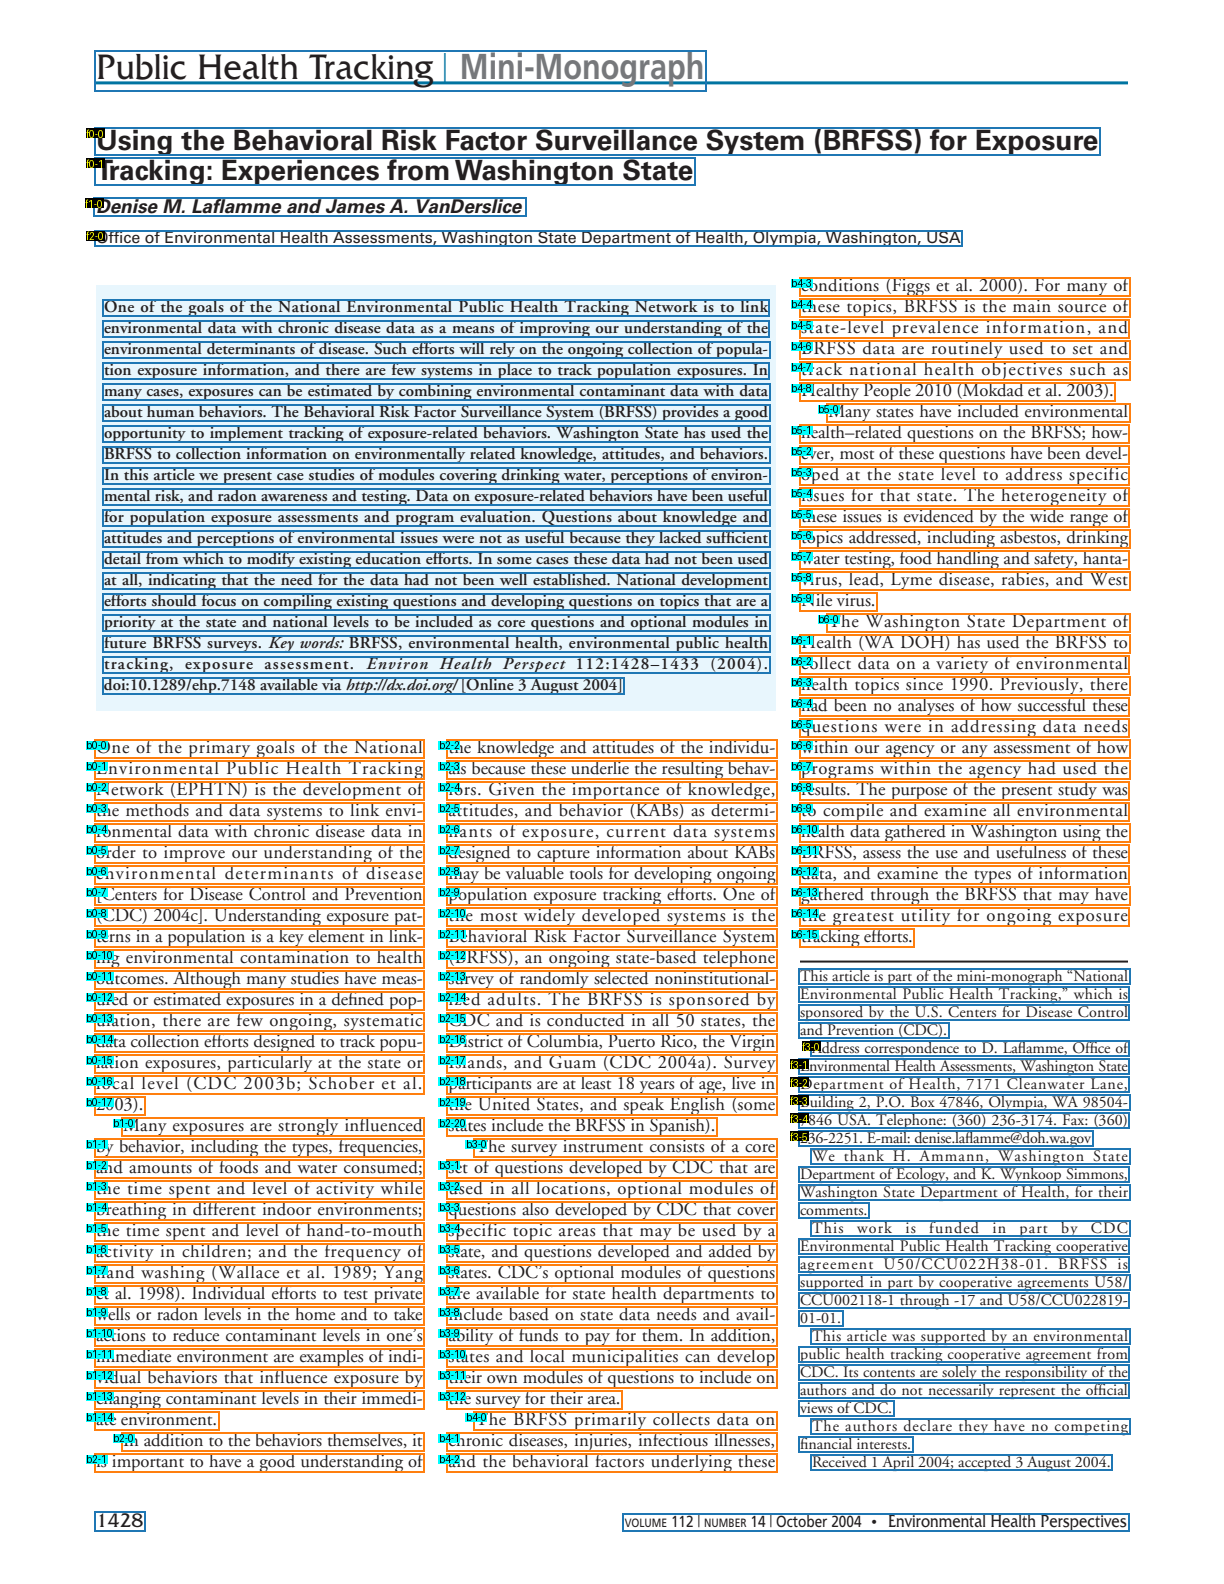

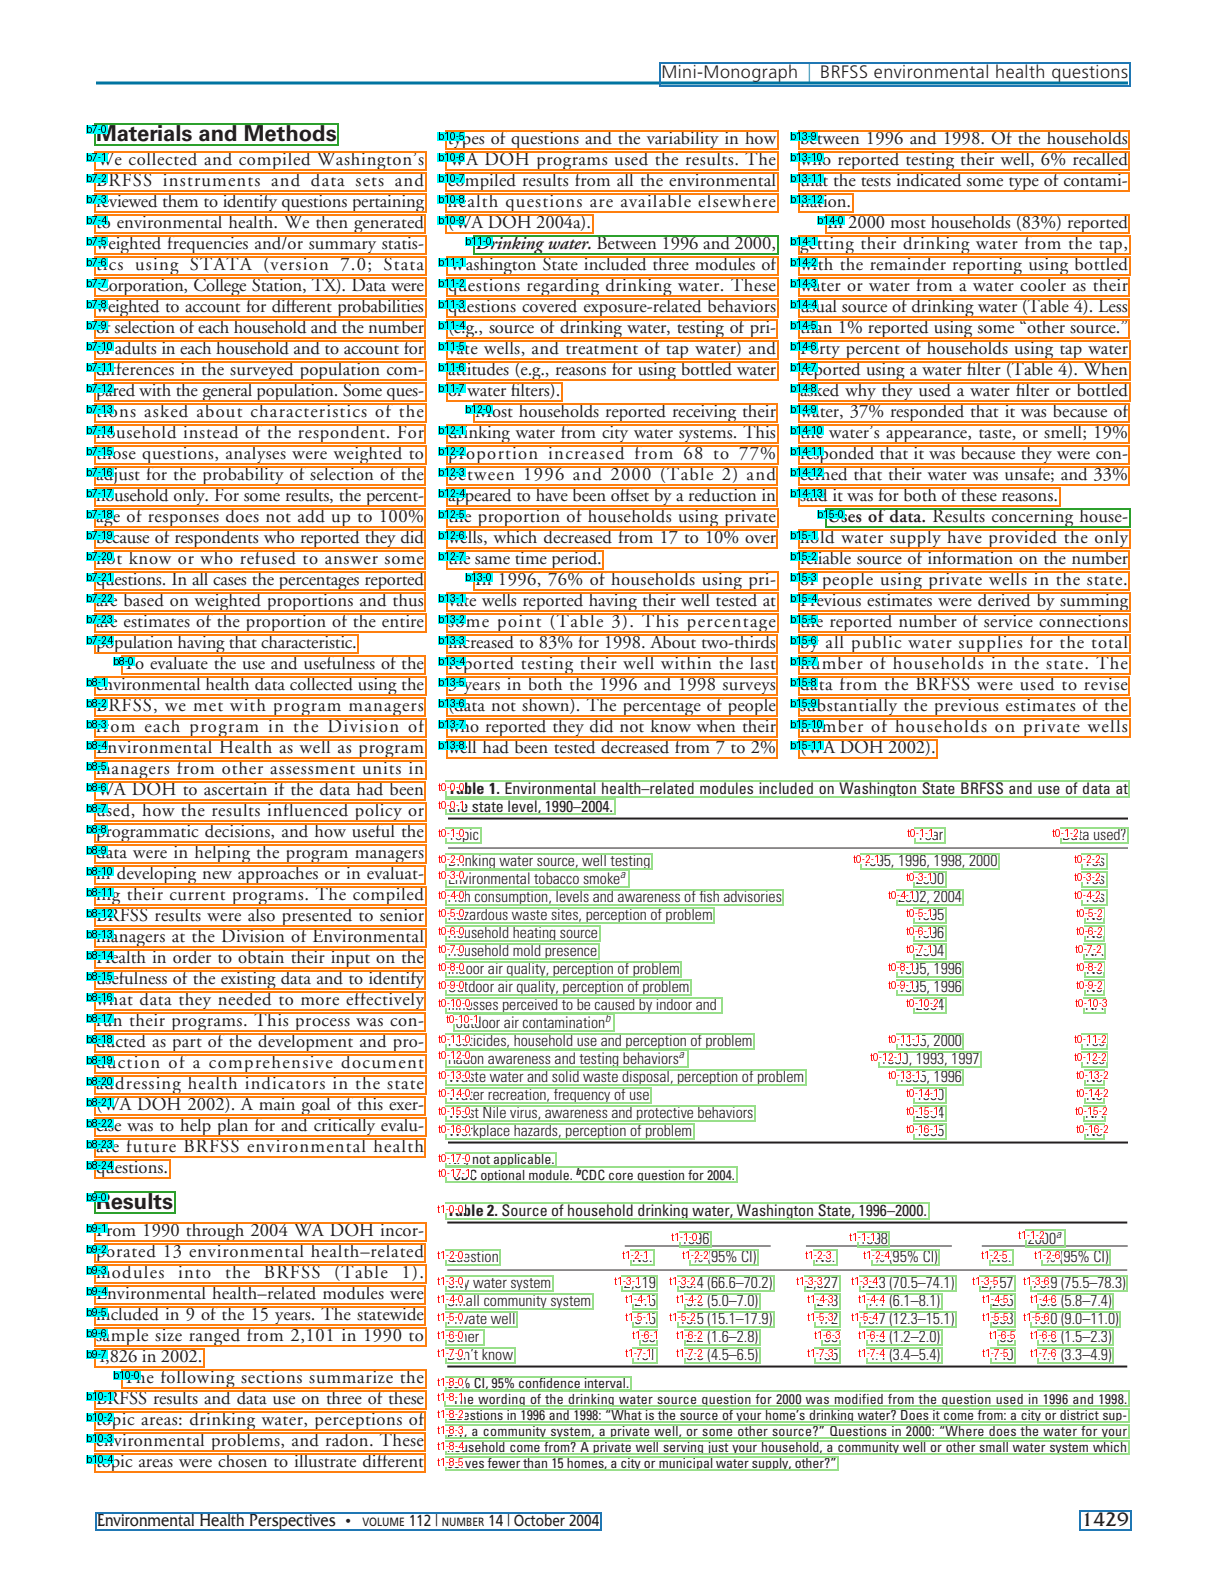

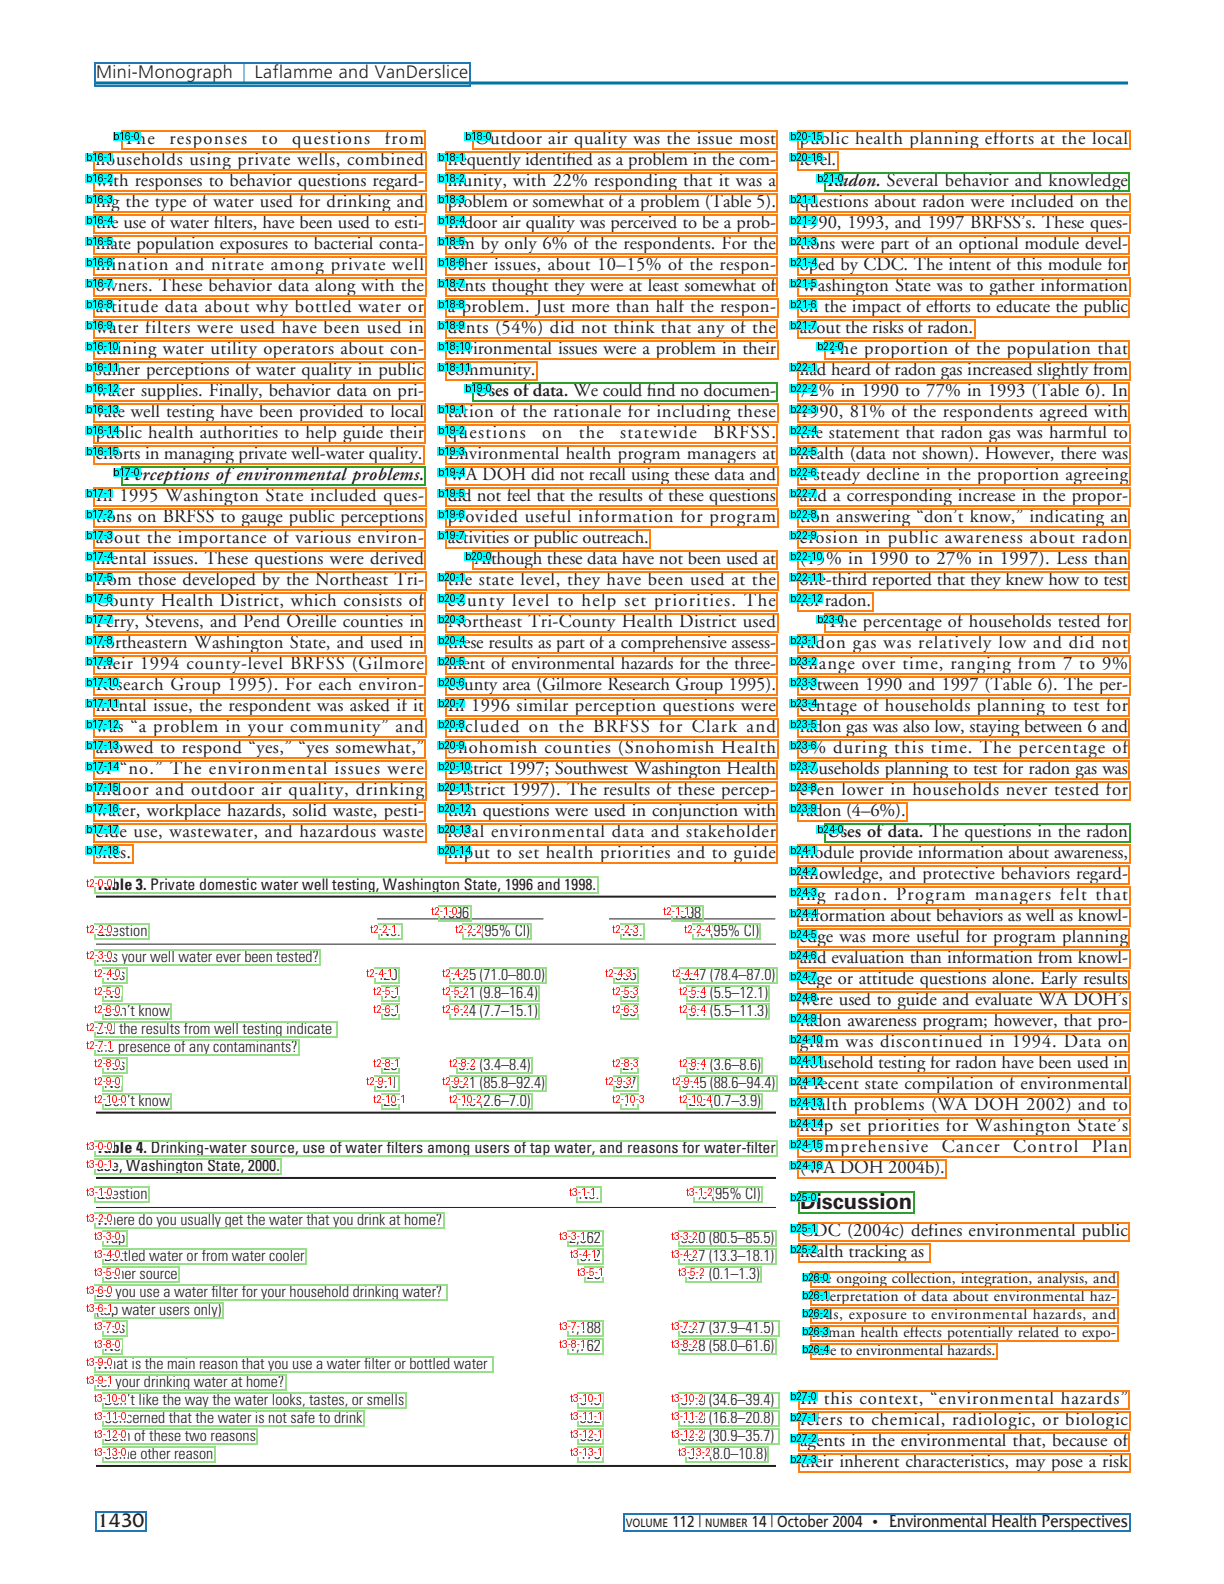

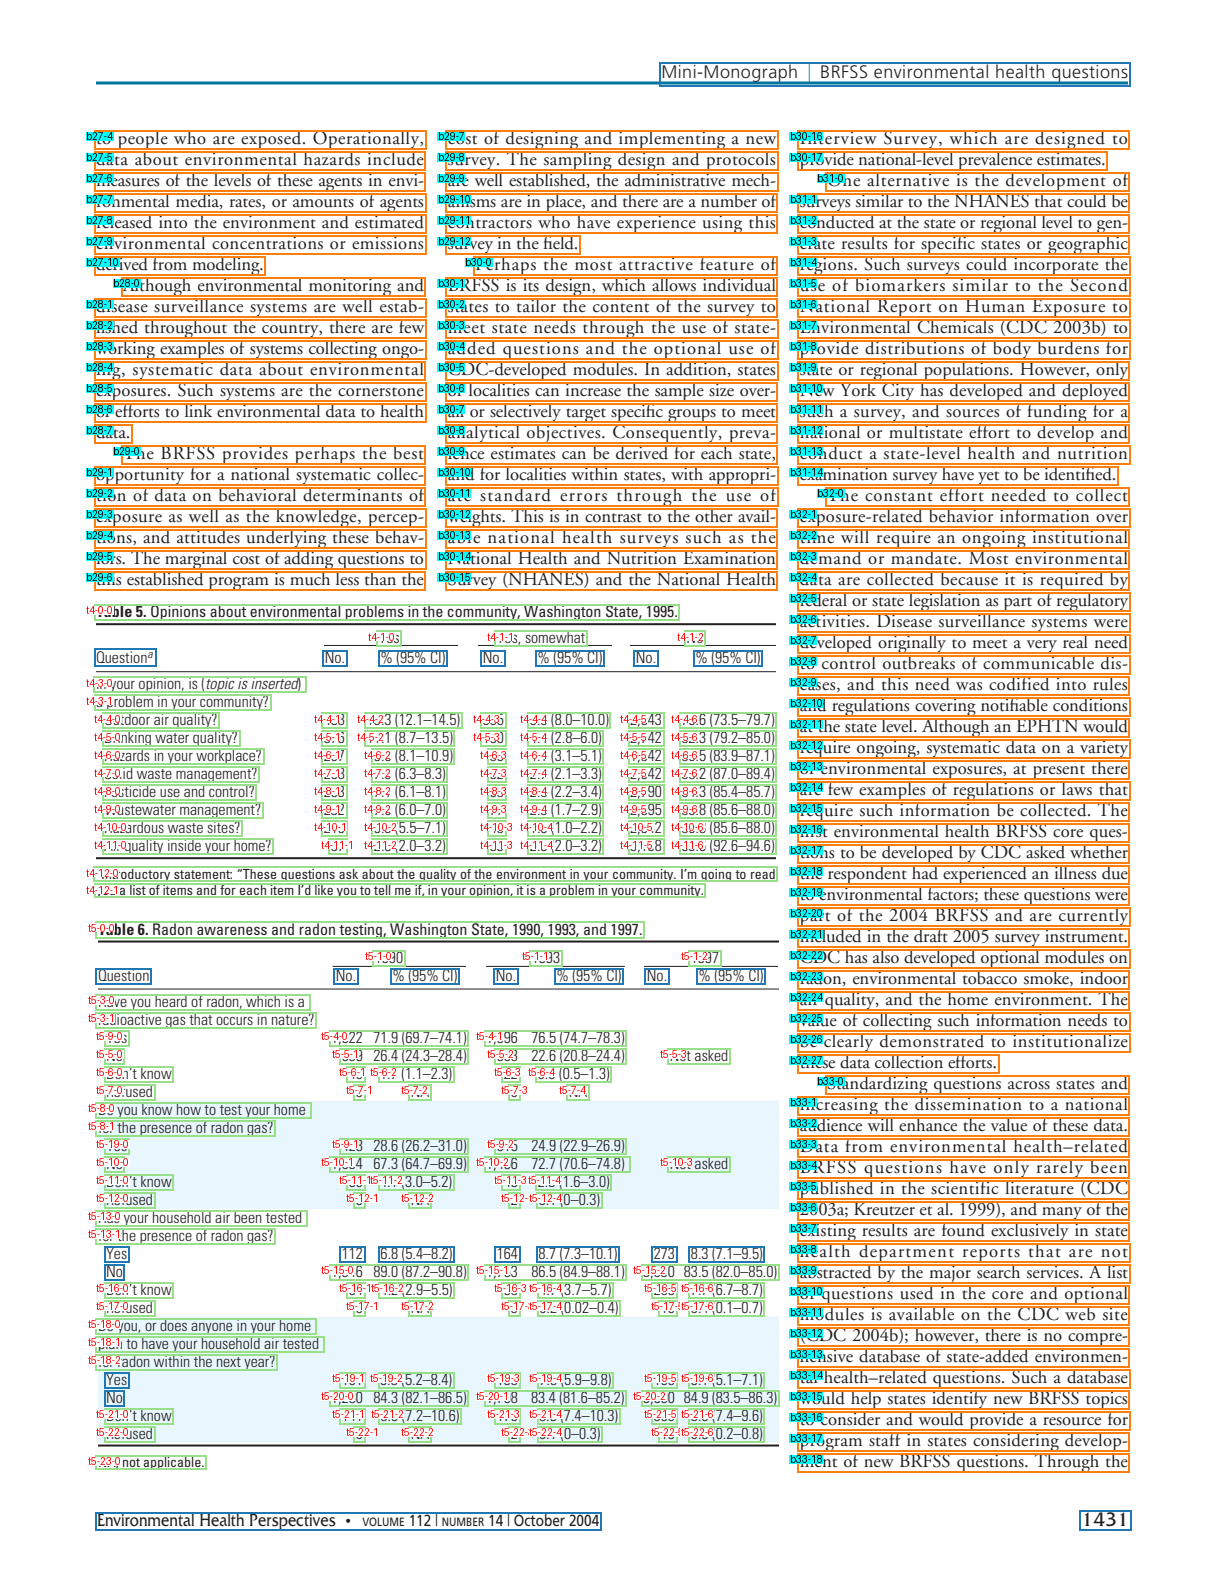

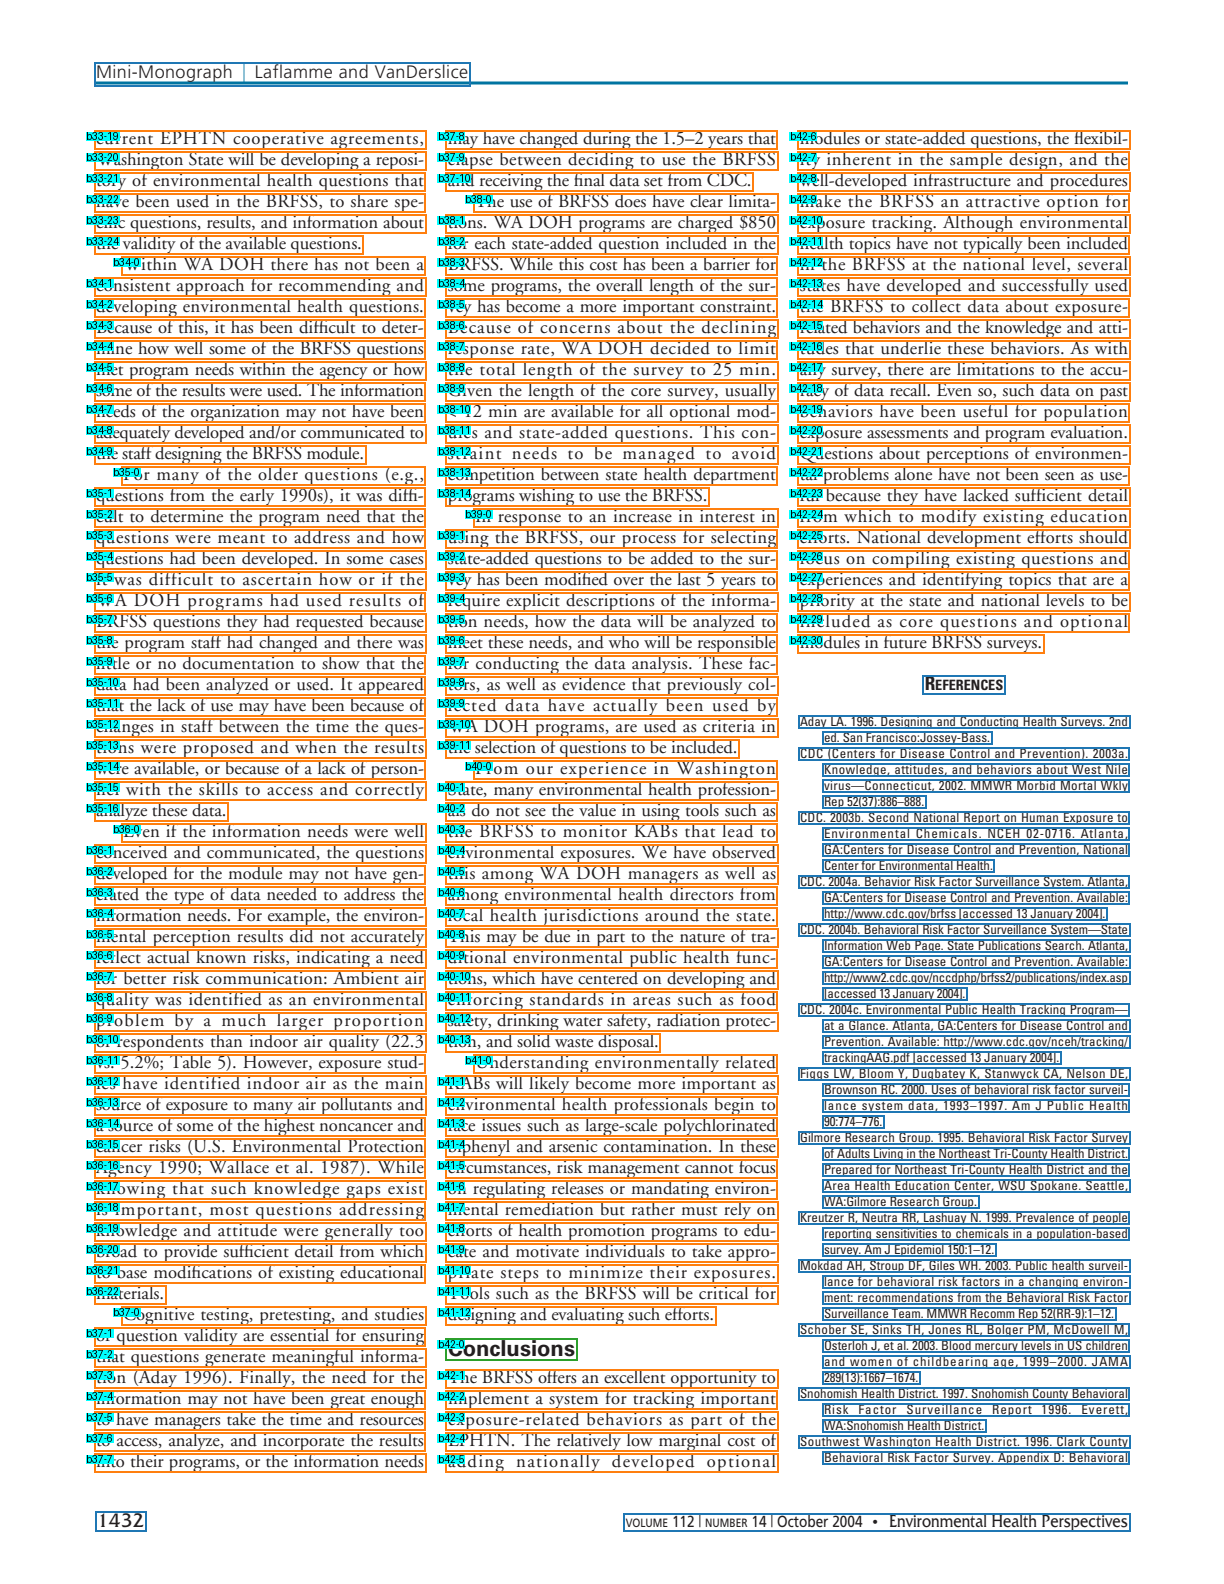

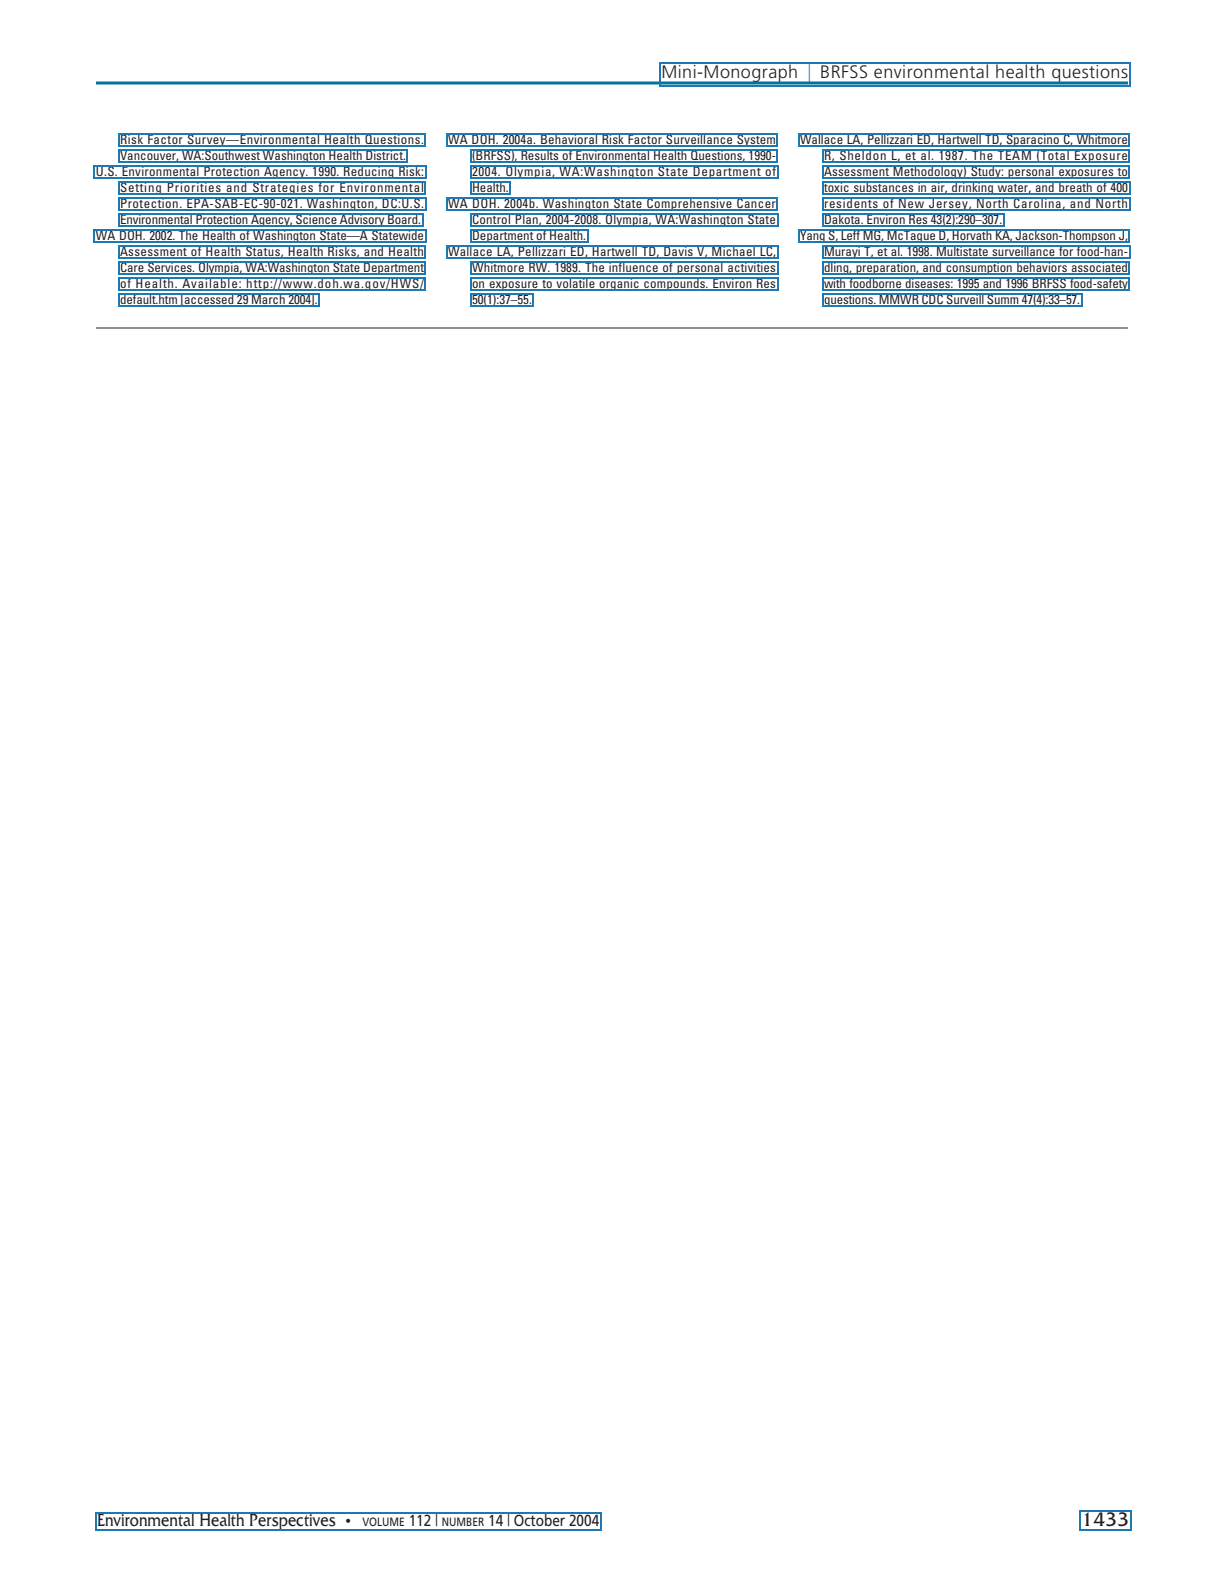

In [115]:
data = {}
k = 2
one_page_only = False
for pmc in xmls_names:
    k -= 1
    if k>0: continue
    
    pdf_path = xmls_dir + pmc + '/' + xmls_names[pmc]['pdf']
    xml_path = xmls_dir + pmc + '/' + xmls_names[pmc]['xml']
    page_num = xmls_names[pmc]['page_num']
    print(f'Page num {page_num}')

    pmc_data = {
        'pdf_path': pmc + '/' + xmls_names[pmc]['pdf'],
        'xml_path': pmc + '/' + xmls_names[pmc]['xml'],
        'nb_pages': 1,
        'lines': []
    }
    
    # Read PDF
    pdf = Path(pdf_path).read_bytes()
    doc: PDFDoc = model.get_pipe("extractor")(pdf)

    if one_page_only:
        _pages_num = [page_num-1, page_num, page_num+1]
        if page_num == 0:
            _pages_num = _pages_num[1:]
        dict_page_text_boxes = {page_num-1: [], page_num: [], page_num+1: []}
        cpt_page_text_boxes = {page_num-1: 0, page_num: 0, page_num+1: 0}
        for tb in doc.content_boxes:
            if tb.page_num in _pages_num: # == page_num: # just one page
                dict_page_text_boxes[tb.page_num].append(tb)
                tb.rank = None
                tb.inode = None
                tb.up_down_left_right = cpt_page_text_boxes[tb.page_num]
                cpt_page_text_boxes[tb.page_num] += 1
    else:   # All pages
        dict_page_text_boxes = {}
        cpt_page_text_boxes = {}
        for tb in doc.content_boxes:
            if tb.page_num not in dict_page_text_boxes:
                dict_page_text_boxes[tb.page_num] = []
                cpt_page_text_boxes[tb.page_num] = 0
            dict_page_text_boxes[tb.page_num].append(tb)
            tb.rank = None
            tb.inode = None
            tb.up_down_left_right = cpt_page_text_boxes[tb.page_num]
            cpt_page_text_boxes[tb.page_num] += 1
        pmc_data['nb_pages'] = len(dict_page_text_boxes)


    # Read XML
    xml = open(xml_path, 'rb')
    tree = etree.parse(xml)
    # root = tree.getroot()

    
    # front nodes matching
    if (not one_page_only) or (page_num == 0):
        xml_front_nodes = get_front_nodes(tree) # xml nodes
        front_nodes = []
        for id,xml_node in enumerate(xml_front_nodes):
            node = Node(xml_node, id, color='yellow', bg_color='black', r0='f',type='front')    # , entropie_threshold=0.1)
            front_nodes.append(node)
        # front_nodes = tqdm(front_nodes, mininterval=1)
        get_matches(front_nodes, {0: dict_page_text_boxes[0]}, v=False)
        for node in front_nodes:
            if node.full:
                if one_page_only:
                    node.filter_bloc(page_num)
                node_lines = node.to_json('front')
                pmc_data['lines'].extend(node_lines)
    # end front nodes matching
    print('front nodes ok')
    
    
    # body nodes matching
    xml_body_nodes = get_body_nodes(tree)   # xml nodes
    body_nodes = []
    for id, xml_node in enumerate(xml_body_nodes):
        node = Node(xml_node, id, color='black', bg_color='cyan', r0='b',type='body')
        body_nodes.append(node)
    # body_nodes = tqdm(body_nodes, mininterval=1)
    get_matches(body_nodes, dict_page_text_boxes, v=False)
    for node in body_nodes:
        if node.full:
            if one_page_only:
                node.filter_bloc(page_num)
            node_lines = node.to_json('body')
            pmc_data['lines'].extend(node_lines)
    # end get body nodes matching
    print('body nodes ok')
    
    
    # tables nodes matching
    xml_table_nodes = get_tables_nodes(tree)    # xml nodes
    table_nodes = []
    for itable,xml_t in enumerate(xml_table_nodes):
        t_nodes = []
        for id,xml_node in enumerate(xml_t):
            node = Node(xml_node, id, color='red', bg_color='white', r0=f't{itable}-',type='table')
            t_nodes.append(node)
        # t_nodes = tqdm(t_nodes, mininterval=1)
        table_nodes.append(t_nodes)
    for itable,t_nodes in enumerate(table_nodes):
        get_matches(t_nodes, dict_page_text_boxes, v=False)
        for node in t_nodes:
            if node.full:
                if one_page_only:
                    node.filter_bloc(page_num)
                node_lines = node.to_json('table', table_num=itable)
                pmc_data['lines'].extend(node_lines)
        print(f'table {1+itable} / {len(table_nodes)} ok')
    # end get tables nodes matching
    data[pmc] = pmc_data
    
    
    # Affichage
    pages = [page for page in show_annotations(doc.content, doc.content_boxes)]
    print(f'Nb pages {len(pages)}')
    if one_page_only:
        for p in _pages_num:
            display(pages[p])
    else:
        for page in pages:
            display(page)
    # printXML(tree)
    
    
    break

In [116]:
pmc

'PMC1247573'

In [114]:
printXML(xml_table_nodes[2][0])

<label_caption>
  <label>Table 4</label>
  <caption>
    <p>Unit values for economic valuation of health end points (2000 US$).</p>
  </caption>
</label_caption>



In [108]:
for xml_node in xml_front_nodes:
    # node = body_nodes[5]
    print(xml_node.tag)
    printXML(xml_node)
    # print(len(xml_node))

article-title
<article-title xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:mml="http://www.w3.org/1998/Math/MathML">Health-Related Benefits of Attaining the 8-Hr Ozone Standard</article-title>

contrib-groups
<contrib-groups>
  <new-name>
    <given-names>Bryan J.</given-names>
    <surname>Hubbell</surname>
  </new-name>
  <vigule>,</vigule>
  <xref ref-type="aff" rid="af1-ehp0113-000073">
    <sup>1</sup>
  </xref>
  <new-name>
    <given-names>Aaron</given-names>
    <surname>Hallberg</surname>
  </new-name>
  <vigule>,</vigule>
  <xref ref-type="aff" rid="af2-ehp0113-000073">
    <sup>2</sup>
  </xref>
  <new-name>
    <given-names>Donald R.</given-names>
    <surname>McCubbin</surname>
  </new-name>
  <vigule>,</vigule>
  <xref ref-type="aff" rid="af2-ehp0113-000073">
    <sup>2</sup>
  </xref>
  <new-name>
    <given-names>Ellen</given-names>
    <surname>Post</surname>
  </new-name>
  <vigule>,</vigule>
  <xref ref-type="aff" rid="af2-ehp0113-000073">
    <sup>2</sup>
  </xre

In [82]:
title_text = ''
p_text = ''

if xml_node.tag == 'title':
    text = unidecode(" ".join(xml_node.itertext()))
    title_text += delete_white_spaces(text)

if xml_node.tag == 'p':
    text = unidecode(" ".join(xml_node.itertext()))
    p_text += delete_white_spaces(text)
    
if xml_node.tag == 'sec':
    for child in xml_node:
        if child.tag == 'title':
            text = unidecode(" ".join(child.itertext()))
            title_text += delete_white_spaces(text)
        if child.tag == 'p':
            text = unidecode(" ".join(child.itertext()))
            p_text += delete_white_spaces(text)


print(f'Title: `{title_text}`')
print(f'P: `{p_text}`')

Title: `Effectestimates:respiratoryhospitaladmissions.`
P: `Detailedhospitaladmissionanddischargerecordsprovidedataforanextensivebodyofliteratureexaminingtherelationshipbetweenhospitaladmissionsandairpollution.Thisisespeciallytrueforthepopulation>=65yearsofage,becauseoftheavailabilityofdetailedMedicarerecords.Becausethenumberofhospitaladmissionstudiesissolarge,weusedresultsfromanumberofstudiestopoolsomehospitaladmissionendpoints.Inaddition,thereisonestudy(Burnettetal.2001)providinganeffectestimateforrespiratoryhospitaladmissionsinchildren<=2yearsofage.`


In [83]:
k = 0
next_tb_title = False
for tb,_ret in node.bloc.ltb_ret:
    if next_tb_title:
        tb.label = 'title'
        next_tb_title = False
        k += 1
        continue
    
    tb_text = unidecode(tb.text)
    tb_text = delete_white_spaces(tb_text)
    ret = tb_match_(tb_text, title_text)
    if ret:
        tb.label = 'title'
        k += 1
        if ret[-1].end < len(title_text)-3:
            next_tb_title = True
    else:
        break

for tb,_ret in node.bloc.ltb_ret[k:]:
    tb.label = 'p'

In [102]:
printXML(tree)

<!DOCTYPE article PUBLIC "-//NLM//DTD JATS (Z39.96) Journal Archiving and Interchange DTD v1.0 20120330//EN" "JATS-archivearticle1.dtd">
<article xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:mml="http://www.w3.org/1998/Math/MathML" article-type="research-article">
  <?properties open_access?>
  <front>
    <journal-meta>
      <journal-id journal-id-type="nlm-ta">Environ Health Perspect</journal-id>
      <journal-id journal-id-type="iso-abbrev">Environ. Health Perspect</journal-id>
      <journal-title-group>
        <journal-title>Environmental Health Perspectives</journal-title>
      </journal-title-group>
      <issn pub-type="ppub">0091-6765</issn>
      <issn pub-type="epub">1552-9924</issn>
      <publisher>
        <publisher-name>National Institue of Environmental Health Sciences</publisher-name>
      </publisher>
    </journal-meta>
    <article-meta>
      <article-id pub-id-type="pmid">15626651</article-id>
      <article-id pub-id-type="pmc">1253713</article-id>
    